In [1]:
from __future__ import division
from __future__ import with_statement
from __future__ import print_function

%load_ext autoreload
%autoreload 2

import numpy as np
import deepmodels
import json
import time
import argparse
import os.path
import subprocess
import imageutils
import utils
import deepmodels_torch
import deepmodels_torch_facenet

In [2]:
# code to change image such that the source image looks more like the target image

In [3]:
with open('datasets/lfw/lfw_binary_attributes.json') as f: lfw=json.load(f)
with open('datasets/lfw/filelist.txt','r') as f: lfw_filelist=['images/'+x.strip() for x in f.readlines()]

In [4]:
backend = 'torch'
device_id = 0
K = 100
scaling = 'beta'
itera = 5000
postprocess=set('color'.split(','))
lfw_path = "./datasets/lfw"
model_type = "facenet" # ----to flag which model to process the interpolation-------

In [5]:
# images of target person 
lfw_target = ["images/lfw/George_W_Bush/"+f for f in os.listdir(lfw_path+'/George_W_Bush') if os.path.isfile(os.path.join(lfw_path+'/George_W_Bush', f))]

In [6]:
lfw_target

['images/lfw/George_W_Bush/George_W_Bush_0001.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0002.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0003.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0004.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0005.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0006.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0007.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0008.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0009.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0010.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0011.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0012.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0013.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0014.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0015.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0016.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0017.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0018.jpg',
 'images/lfw/George_W_Bush/George_W_Bush_0019.jpg',
 'images/lfw

In [7]:
minimum_resolution=200
if backend=='torch':
    if model_type == "facenet":
        model=deepmodels_torch_facenet.facenet_torch(device_id=device_id)
    elif model_type == "imagenet":
        model=deepmodels_torch.vgg19g_torch(device_id=device_id)
elif backend=='caffe+scipy':
    model=deepmodels.vgg19g(device_id=device_id)
else:
    raise ValueError('Unknown backend')

In [8]:
# preprocessed lfw images that have the aligned face without the background
if not os.path.exists('images/lfw_aegan'):
    url='https://www.dropbox.com/s/isz4ske2kheuwgr/lfw_aegan.tar.gz?dl=1'
    subprocess.check_call(['wget',url,'-O','lfw_aegan.tar.gz'])
    subprocess.check_call(['tar','xzf','lfw_aegan.tar.gz'])
    subprocess.check_call(['rm','lfw_aegan.tar.gz'])

In [9]:
# list of sounce image that needs to be changed. All souce images will be made like the average of the target image
X = ['images/lfw/Tom_Hanks/Tom_Hanks_0005.jpg']

In [10]:
K=200
delta = '0.4'
delta_params=[float(x.strip()) for x in delta.split(',')]
# t0=time.time()
result=[]
original=[]

In [11]:
for i in range(len(X)):
    result.append([])
    xX=X[i].replace('lfw','lfw_aegan')
    o=imageutils.read(xX)

In [12]:
image_dims=o.shape[:2]

In [13]:
if min(image_dims)<minimum_resolution:
    s=float(minimum_resolution)/min(image_dims)
    image_dims=(int(round(image_dims[0]*s)),int(round(image_dims[1]*s)))
    o=imageutils.resize(o,image_dims)

In [14]:
XF=model.mean_F([o])

/home/rw565/FaceDetection/deepfeatinterp/deepmodels_torch_facenet.py:152: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = Variable(input, volatile=True).cuda()


In [15]:
original.append(o)

In [16]:
xP = [x.replace('lfw','lfw_aegan') for x in lfw_target]
# xQ=[x.replace('lfw','lfw_aegan') for x in lfw_filelist[np.random.choice(len(lfw_filelist), K, replace=False)]]
xQ=[lfw_filelist[i].replace('lfw','lfw_aegan') for i in np.random.choice(len(lfw_filelist), K, replace=False)]

In [17]:
PF=model.mean_F(utils.image_feed(xP[:K],image_dims))
QF=model.mean_F(utils.image_feed(xQ[:K],image_dims))

In [18]:
if scaling=='beta':
    WF=(PF-QF)/((PF-QF)**2).mean()
elif scaling=='none':
    WF=(PF-QF)
max_iter=itera
init=o

In [19]:
for delta in delta_params:
    print(xX,delta)
    t2=time.time()
    Y=model.F_inverse(XF+0.3*WF,max_iter=max_iter,initial_image=init)
#     Y=model.F_inverse(PF,max_iter=max_iter,initial_image=init)
    t3=time.time()
    print('{} minutes to reconstruct'.format((t3-t2)/60.0))
    result[-1].append(Y)
    max_iter=itera//2
    init=Y

images/lfw_aegan/Tom_Hanks/Tom_Hanks_0005.jpg 0.4


/home/rw565/anaconda2/envs/dfi_attack/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1.1928994099299113 minutes to reconstruct


In [20]:
print(result[-1])

[array([[[0.0999322 , 0.01631391, 0.08443113],
        [0.093527  , 0.05768851, 0.09029286],
        [0.02727903, 0.        , 0.04169824],
        ...,
        [0.10418534, 0.069332  , 0.10752013],
        [0.04914129, 0.        , 0.08554948],
        [0.19222352, 0.12911613, 0.19993179]],

       [[0.08165368, 0.05881799, 0.0885748 ],
        [0.03116836, 0.00381258, 0.05125707],
        [0.01888152, 0.00935618, 0.0496969 ],
        ...,
        [0.04166974, 0.02228342, 0.0570328 ],
        [0.00527273, 0.        , 0.05347123],
        [0.11846506, 0.0618015 , 0.14963558]],

       [[0.02793679, 0.00342657, 0.03983895],
        [0.03645821, 0.        , 0.04425331],
        [0.04140401, 0.03391381, 0.06504638],
        ...,
        [0.02368733, 0.05155296, 0.04262832],
        [0.01892684, 0.03113903, 0.07169659],
        [0.13634223, 0.08167584, 0.16820586]],

       ...,

       [[0.30914035, 0.29995126, 0.28173587],
        [0.2477166 , 0.28933007, 0.23533137],
        [0.22041164, 

In [21]:
result=np.asarray(result)
original=np.asarray(original)

In [22]:
if 'color' in postprocess:
    result=utils.color_match(np.expand_dims(original,1),result)

Computing color match (1, 1, 200, 200, 3) (1, 1, 200, 200, 3)


In [23]:
m=imageutils.montage(np.concatenate([np.expand_dims(original,1),result],axis=1))

In [24]:
imageutils.write('results/demo1tb7d_{}.png'.format(model_type),m)

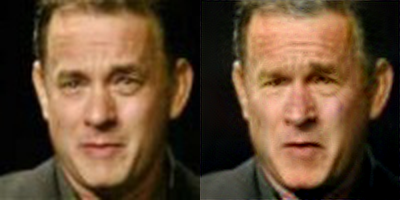

In [25]:
from IPython.display import Image
Image(filename='results/demo1tb7d_imagenet.png') 

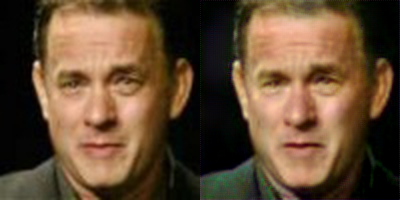

In [26]:
Image(filename='results/demo1tb7d_facenet.png') 